<a href="https://colab.research.google.com/github/realfolkcode/clip-robust-gen/blob/main/clip_robust_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robust CLIP image generation

The notebook author: [realfolkcode](https://github.com/realfolkcode)

In this minimalist notebook, we generate images from a given text prompt by traversing through the gradients of [Robust CLIP (ICML 2024, Schlarman et al.)](https://arxiv.org/pdf/2402.12336) **without a generative model**. Generating images from the gradients of a classifier is by no means a novel idea (see, for example, [this paper](https://proceedings.neurips.cc/paper_files/paper/2019/file/6f2268bd1d3d3ebaabb04d6b5d099425-Paper.pdf)). Several approaches have used CLIP to synthesize/search for an image that is similar to a prompt (e.g., [CLIPig](https://github.com/defgsus/clipig)). However, its gradients are not suitable for generation since CLIP's image encoder is sensitive to small imperceptible perturbations and adversarial attacks. As such, a naive gradient descent may result in semantically poor images that have high CLIP similarity scores. To alleviate this issue, CLIPig augments samples with noise, random rotations, etc. Contrary to this, robust classifiers have *perceptually-aligned gradients* and perform better at generative tasks, as shown by [Srinivas et al.](https://arxiv.org/pdf/2305.19101) This motivated me to check how well Robust CLIP would work in **straightforward** settings (i.e., without the need to introduce tricky augmentations).

## Import and install

In [ ]:
!pip install open_clip_torch

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms.v2 as v2
from PIL import Image, ImageDraw
import open_clip
import numpy as np
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load model

In [ ]:
clip, _, processor = open_clip.create_model_and_transforms('hf-hub:chs20/fare2-clip')

# Uncomment the line below if you want to try the original non-robust CLIP model
#clip, _, processor = create_model_and_transforms('ViT-L-14', pretrained='openai')

clip = clip.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

In [ ]:
tokenizer = open_clip.get_tokenizer('ViT-B-32')

## Utils

In [ ]:
def loss_fn(x):
    text = tokenizer(prompt).to(device)
    image_features = clip.encode_image(x)
    text_features = clip.encode_text(text)
    loss = F.cosine_similarity(image_features, text_features)
    return loss

Here, we define a schedule for the guidance strength. A schedule depends on the current iteration number as well as the overall number of steps. In my non-exhaustive experiments I found that a monotonously decaying cosine schedule works well. You can define your own schedule. Please, let me know if you get some interesting results.

In [ ]:
class CosineSchedule:
    def __init__(self,
                 num_steps: int,
                 phase_coef: float = 0.9):
        self.num_steps = num_steps
        self.max_phase = phase_coef * np.pi / 2

    def __call__(self, iter: int):
        s = np.cos(iter / self.num_steps * self.max_phase)
        return s

## Generate

In [ ]:
# Specify your prompt

#prompt = "dark fantasy poster in the style of Dragon Age games, sharp photo, ultrarealistic"
#prompt = "photo of a cat playing blues on a guitar, ultrarealistic, sharp"
prompt = "Cheburashka in a sombrero stands on three turtles, ultrarealistic, sharp photo, high quality"

In the cell below, we define the following parameters:

`img_size`: The size of a downsampled image. CLIP operates with images of the size of 224x224. However, the resulting images are too noisy in the original resolution. Synthesizing in a lower resolution results in smoother images. Before each step of gradient descent, we downsample the current image.

`num_steps`: The number of gradient descent steps.

`batch_size`: The number of images to produce.

In [ ]:
img_size = 112
downsample = v2.Resize((img_size, img_size), antialias=True)
upsample = v2.Resize((224, 224), antialias=True)

num_steps = 100
scheduler = CosineSchedule(num_steps=num_steps)
batch_size = 2

Run the cell below to start generation.

Under the hood, we first initialize an image with a Gaussian noise. Then, we run several steps of projected gradient descent (w.r.t. image) to maximize the similarity between the text and image features. The gradient is normalized and rescaled with the image size and guidance strength schedule. Next, the image is projected such that its pixel values lie in $[-1, 1]$.

In [ ]:
# Initializing images with Gaussian noise.

x = torch.randn(batch_size, 3, 8, 8).to(device)

x[0, 0, :, :] *= 0.26862954
x[0, 1, :, :] *= 0.26130258
x[0, 2, :, :] *= 0.27577711

x[0, 0, :, :] += 0.48145466
x[0, 1, :, :] += 0.4578275
x[0, 2, :, :] += 0.40821073

x = x.requires_grad_()

################################################

verbose = 5

for i in tqdm(range(num_steps)):
    x = x.detach().requires_grad_()
    x = upsample(x)
    loss = loss_fn(x)
    loss = list(loss)
    if i % verbose == 0:
        print([elem.item() for elem in loss])

    grad = torch.autograd.grad(loss, x)
    grad = torch.cat(grad)
    grad = grad / torch.linalg.vector_norm(grad, dim=[1,2,3]).view(-1, 1, 1, 1)
    s = scheduler(i)
    x = x + img_size * s * grad
    x = x.clamp(-1, 1)
    x = downsample(x)

  0%|          | 0/100 [00:00<?, ?it/s]

[0.1296205222606659, 0.13831326365470886]


  6%|▌         | 6/100 [00:03<00:32,  2.92it/s]

[0.1968640685081482, 0.2802385091781616]


 11%|█         | 11/100 [00:04<00:22,  3.96it/s]

[0.3209848999977112, 0.32734036445617676]


 16%|█▌        | 16/100 [00:05<00:19,  4.37it/s]

[0.322876513004303, 0.3983842134475708]


 21%|██        | 21/100 [00:06<00:18,  4.34it/s]

[0.36962658166885376, 0.38401684165000916]


 26%|██▌       | 26/100 [00:08<00:17,  4.35it/s]

[0.39476126432418823, 0.386763334274292]


 31%|███       | 31/100 [00:09<00:15,  4.33it/s]

[0.42252618074417114, 0.40623101592063904]


 36%|███▌      | 36/100 [00:10<00:14,  4.28it/s]

[0.46251213550567627, 0.43698829412460327]


 41%|████      | 41/100 [00:11<00:13,  4.36it/s]

[0.4198944568634033, 0.43136632442474365]


 46%|████▌     | 46/100 [00:12<00:12,  4.35it/s]

[0.4721723198890686, 0.44587281346321106]


 51%|█████     | 51/100 [00:13<00:11,  4.35it/s]

[0.4417700171470642, 0.46664005517959595]


 56%|█████▌    | 56/100 [00:14<00:10,  4.34it/s]

[0.47358325123786926, 0.4654819965362549]


 61%|██████    | 61/100 [00:16<00:09,  4.29it/s]

[0.4549233913421631, 0.43044400215148926]


 66%|██████▌   | 66/100 [00:17<00:07,  4.33it/s]

[0.47416120767593384, 0.4265778064727783]


 71%|███████   | 71/100 [00:18<00:06,  4.32it/s]

[0.4733773469924927, 0.45525822043418884]


 76%|███████▌  | 76/100 [00:19<00:05,  4.32it/s]

[0.4348772466182709, 0.467159628868103]


 81%|████████  | 81/100 [00:20<00:04,  4.30it/s]

[0.4991908073425293, 0.46840089559555054]


 86%|████████▌ | 86/100 [00:21<00:03,  4.08it/s]

[0.4498293995857239, 0.47771793603897095]


 91%|█████████ | 91/100 [00:23<00:02,  4.34it/s]

[0.4790821671485901, 0.4930582046508789]


 96%|█████████▌| 96/100 [00:24<00:00,  4.28it/s]

[0.5051782727241516, 0.4646819233894348]


100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


In [ ]:
# Upsample to the original resolution and convert to PIL images

images = upsample(x).detach().cpu()
images = (images / 2 + 0.5).clamp(0, 1)
images = images.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (images * 255).round().astype('uint8')
pil_images = [Image.fromarray(image) for image in images]

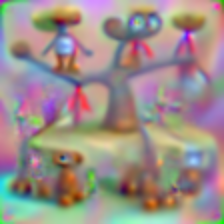

In [ ]:
pil_images[0]

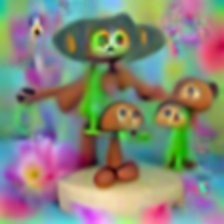

In [ ]:
pil_images[1]